In [1]:
import numpy as np 

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVR # nu-SVR, implement from libsvm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn import preprocessing
# different regressor test

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

import pandas as pd # process txt
from scipy.io import loadmat
from PIL import Image

from collections import defaultdict

# 150x312的输入，312x1024的矩阵，变换为150x1024的输出
import torch 
#import torch.nn as nn
#import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
folder = "G:/dataset/cub/CUB_200_2011/"
standard_path = "G:/dataset/standard_split/CUB/"
proposed_path = "G:/dataset/proposed_split/CUB/"

cls_to_idx = {}
with open(folder + "classes.txt", "r", encoding='utf-8') as f:
     for row in f.readlines():
         row = row.rstrip()
         idx, name = row.split()
         cls_to_idx[name] = int(idx) - 1 # custom will -1

sstrain, sstest = [], []
pstrain, pstest = [], []

# Standard Split 
with open(standard_path + "trainvalclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        sstrain.append(cls_to_idx[row])

with open(standard_path + "testclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        sstest.append(cls_to_idx[row])

print("standard_split:", len(sstrain), len(sstest))
# transform List(str) -> List(int)

# Proposed Split
with open(proposed_path + "trainvalclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        pstrain.append(cls_to_idx[row])

with open(proposed_path + "testclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        pstest.append(cls_to_idx[row])

print("proposed_split:", len(pstrain), len(pstest))


# Random Train & Test Class Split

train_class, test_class = [], [] # (5994, 5794)
X_class = list(range(200)) # label start from 0, you can adjust it
train_class, test_class = train_test_split(X_class, test_size=0.2)

#train_class, test_class = sstrain, sstest
train_class, test_class = pstrain, pstest



standard_split: 150 50
proposed_split: 150 50


In [3]:
test_class[:10]

[42, 110, 22, 97, 54, 129, 138, 122, 155, 123]

In [4]:
class cubRead:
    def __init__(self, p, train_split):
        """
        p: 数据集存放路径
        train_split: 给出训练集
        """
        X_class = list(range(200)) # custom: range(200)
        train_class = train_split
        test_class = list(filter(lambda i: i not in train_class, X_class))
        self.path = p
        # labels
        yp = self.path + "custom-cub-labels.txt"
        y = np.loadtxt(yp, delimiter=" ", encoding='utf-8')
        # visual features 2048 dimensions
        xp = self.path + "custom-cub-features.txt"
        x = np.loadtxt(xp, delimiter=" ", encoding='utf-8')
        self.i1 = np.isin(y, train_class)
        self.i2 = np.isin(y, test_class)
        self.X_train, self.X_test = x[self.i1], x[self.i2]
        self.y_train, self.y_test = y[self.i1], y[self.i2]
    def index_train_test(self):
        return [self.i1, self.i2]
    def train_data(self):
        return self.X_train, self.y_train
    def test_data(self):
        return self.X_test, self.y_test
    def test(self): # 11788 all, add them to test
        print(self.X_train.shape, self.y_train.shape)
        print(self.X_test.shape, self.y_test.shape)

cubReader = cubRead(folder, train_class)
cubReader.test() 
# proposed split:
# custom: 8821 + 2967
# their evaluation: 8844 + 2944

(8821, 2048) (8821,)
(2967, 2048) (2967,)


### EDA with semantic embedding


In [5]:
# original
# semantic embedding of CUB, 200 birds, 312 attributes
se = folder + "attributes/class_attribute_labels_continuous.txt"
semat = np.loadtxt(se, delimiter=" ", encoding='utf-8')
semat.shape

(200, 312)

In [6]:
X_train, y_train = cubReader.train_data()
X_test, y_test = cubReader.test_data()
#X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Hyper_parameter
pca_d = 500

exemPCA = decomposition.PCA(n_components=pca_d)
exemPCA.fit(X_train)
X_train = exemPCA.transform(X_train)
X_test = exemPCA.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8821, 500), (8821,), (2967, 500), (2967,))

In [7]:
# group up PCA projections

exem_train_group = defaultdict(list)

for c in train_class:
    exem_train_group[c] = []
        
for x, y in zip(X_train, y_train):
    exem_train_group[y].append(x)

# Average
exem_train = {}
std_train = {}
# standard deviation
k = 0

for item in exem_train_group.items():
    y, ary = item
    exem_train[y] = np.mean(ary, axis=0) # Key Sentence
    std_train[y] = np.std(ary, axis=0)

del exem_train_group


# class to index, the same
se = folder + "attributes/class_attribute_labels_continuous.txt"
semat = np.loadtxt(se, delimiter=" ", encoding='utf-8')
semat = preprocessing.normalize(semat, norm='l2')

a_c_train, a_c_test = semat[train_class], semat[test_class]
v_c_train = [exem_train[i] for i in train_class] # dict uses classes to index
sd_train = [std_train[i] for i in train_class]
sd_train = np.mean(sd_train, axis=0)

In [8]:
np.array(a_c_train).shape, np.array(v_c_train).shape, np.array(sd_train).shape

((150, 312), (150, 500), (500,))

## 第2步 
### Training

用MLP训练，可以用Torch或者Sklearn


X为语义表示，是固定的a_c_train矩阵，维度为150x85转换为150x1024

$$\psi (a_c) \approx v_c$$

In [9]:
###
x, y = torch.tensor(np.array(a_c_train), dtype=torch.float), torch.tensor(np.array(v_c_train), dtype=torch.float)

In [10]:
# Torch Training

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 30, 312, 400, pca_d
# Create random Tensors to hold inputs and outputs
#x, y = torch.randn(N, D_in), torch.randn(N, D_out)
# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
   #torch.nn.Dropout(p=0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
# model.load_state_dict(torch.load("ffp_cub.pth")) 注意pca_d 不匹配的问题

In [11]:
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
for t in range(2000):
    # Forward pass: compute predicted y by passing x to the model.
    for i in range(len(x)//N):
        inputs = x[i*N:i*N + N]
        labels = y[i*N:i*N + N]
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
    if t % 100 == 99:
        print(t, loss.item())

99 1647.5634765625
199 1083.167724609375
299 857.2839965820312
399 726.1152954101562
499 643.7552490234375
599 581.5565795898438
699 529.8699951171875
799 485.3159484863281
899 446.0465087890625
999 410.85223388671875
1099 378.63214111328125
1199 349.10870361328125
1299 321.9333190917969
1399 296.9659729003906
1499 273.99237060546875
1599 252.81253051757812
1699 233.4409942626953
1799 215.4845733642578
1899 198.72471618652344
1999 183.10086059570312


In [12]:
model.eval()
#test_x = torch.randn(10, 85)
test_y = model(torch.tensor(a_c_test, dtype=torch.float))
test_y.shape
v_c_test = test_y.detach().numpy()
# v_c_test = np.zeros((10, 1024)) # 提前定义好exemplar矩阵

v_c_test.shape, len(v_c_train), len(v_c_train[0])

exem_X, exem_y = [], []

for i, c in enumerate(test_class):
    exem_X.append(v_c_test[i])
    exem_y.append(c)

# Add this part to become GZSL
#for i, c in enumerate(train_class):
#    exem_X.append(v_c_train[i])
#    exem_y.append(c)

#X_test.shape
# exem_X.shape, exem
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(exem_X, exem_y)
print("1NN:{} ".format(neigh.score(X_test, y_test)))




sneigh = KNeighborsClassifier(n_neighbors=1, metric='seuclidean', 
                    metric_params={'V':sd_train})
sneigh.fit(exem_X, exem_y)
print("1NNs:{}".format(sneigh.score(X_test, y_test)))

1NN:0.5635321873946748 
1NNs:0.6073474890461746


### Example Log of Training:

```
必须要标准化

99 1660.460205078125
199 1085.3917236328125
299 869.2305908203125
399 738.476318359375
499 655.2228393554688
599 593.5831909179688
699 542.520751953125
799 498.0696105957031
899 458.3826599121094
999 422.5646057128906
1099 389.8522033691406
1199 359.6669921875
1299 331.66436767578125
1399 305.89306640625
1499 282.1407775878906
1599 260.1086120605469
1699 239.75042724609375
1799 220.84164428710938
1899 203.30210876464844
1999 187.00010681152344

1NN:0.564206268958544 
1NNs:0.5992585102797439
```

In [13]:
imgs = np.loadtxt(folder + "custom-cub-filenames.txt", dtype=str, encoding='utf-8')
train_index, test_index = cubReader.index_train_test()
i_to_c = {}

with open(folder + "classes.txt", "r", encoding='utf-8') as f:
     for row in f.readlines():
         row = row.rstrip()
         idx, name = row.split()
         i_to_c[int(idx) - 1] = name# custom will -1
        
# imgs[test_index]
ary = sneigh.predict(X_test)
temp = ary == y_test

In [14]:
len(temp), len(imgs[test_index])

(2967, 2967)

In [15]:
sneigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='seuclidean',
                     metric_params={'V': array([2.01480433, 2.06223782, 2.08242693, 2.0729464 , 2.15257366,
       1.92555801, 1.8459353 , 1.59067166, 1.61526206, 1.55537066,
       1.53369612, 1.61301802, 1.44570541, 1.59388386, 1.5238932 ,
       1.54180557, 1.52684587, 1.38811528, 1.54950836, 1.38200657,
       1.44143737, 1.41787347, 1.34229744, 1.2...
       0.12067049, 0.12098639, 0.12031583, 0.11973822, 0.12032334,
       0.11933011, 0.11956823, 0.11953387, 0.11893382, 0.11905747,
       0.11843448, 0.11854901, 0.11808905, 0.11807856, 0.11767523,
       0.11745658, 0.11766771, 0.11710252, 0.1167844 , 0.11567537,
       0.11567566, 0.11500411, 0.11514372, 0.11545908, 0.11473252,
       0.11449735, 0.11428658, 0.11450424, 0.11321697, 0.11345069])},
                     n_jobs=None, n_neighbors=1, p=2, weights='uniform')

exem_y

In [22]:
neigh_dist, neigh_indices = sneigh.kneighbors(X_test[[333]], n_neighbors=5)
neigh_indices

array([[ 0, 16, 26, 33, 28]], dtype=int64)

In [36]:
from matplotlib.pyplot import imshow

def predict(ix, paths):
    print("预测: ")
    l = sneigh.predict(X_test[[ix]])
    print("    " + i_to_c[l[0]])
    print("实际:")
    print("    " + paths[ix].split('\\')[1])
    print("邻居[类别, 距离]:")
    neigh_dist, neigh_indices = sneigh.kneighbors(X_test[[ix]], n_neighbors=5)
    for d, i in zip(neigh_dist[0], neigh_indices[0]):
        ti = exem_y[i]
        print("   " + i_to_c[ti], d, sep=", ")
    im = Image.open(paths[ix])
    imshow(im)
    print(temp[ix])

预测: 
    043.Yellow_bellied_Flycatcher
实际:
    031.Black_billed_Cuckoo
邻居[类别, 距离]:
   043.Yellow_bellied_Flycatcher, 15.844288124478469
   103.Sayornis, 15.87458815627299
   033.Yellow_billed_Cuckoo, 15.87997239710171
   091.Mockingbird, 16.081265180931368
   031.Black_billed_Cuckoo, 16.130016949349105
False


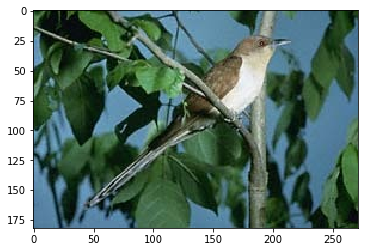

In [38]:
predict(333, imgs[test_index])

预测: 
    072.Pomarine_Jaeger
实际:
    072.Pomarine_Jaeger
邻居[类别, 距离]:
   072.Pomarine_Jaeger, 18.58863619691537
   052.Pied_billed_Grebe, 19.410541774717906
   033.Yellow_billed_Cuckoo, 19.639925015193107
   045.Northern_Fulmar, 19.66656367133189
   031.Black_billed_Cuckoo, 19.750967726839328
True


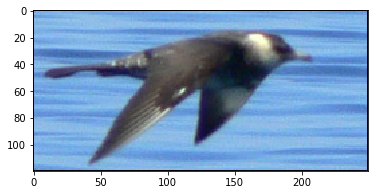

In [39]:
predict(777, imgs[test_index])

### Original

```
regress_group = []
k = 0
for j in range(pca_d):
    X = a_c_train # 
    y = [vc[j] for vc in v_c_train]
    #regressor = MLPRegressor(hidden_layer_sizes=(100, 50))
    regressor = NuSVR(C=2.0)
    regressor.fit(X, y)
    regress_group.append(regressor)

v_c_test = np.zeros((50, pca_d)) # 提前定义好exemplar矩阵, 200 * 0.2, standard split=50 test classes
# 对每一个维度进行预测
for j in range(pca_d):
    v_c_test[:, j] =  regress_group[j].predict(a_c_test) # 10 dimension , assign to column

v_c_test.shape, len(v_c_train), len(v_c_train[0])
# also add up to 200 here
exem_X, exem_y = [], []

for i, c in enumerate(test_class):
    exem_X.append(v_c_test[i])
    exem_y.append(c)

# Add this part to become GZSL
#for i, c in enumerate(train_class):
#    exem_X.append(v_c_train[i])
#    exem_y.append(c)

#X_test.shape
# exem_X.shape, exem

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(exem_X, exem_y)
print("1NN:{} ".format(neigh.score(X_test, y_test)))

sneigh = KNeighborsClassifier(n_neighbors=1, metric='seuclidean', 
                    metric_params={'V':sd_train})
sneigh.fit(exem_X, exem_y)
print("1NNs:{}".format(sneigh.score(X_test, y_test)))
```

In [ ]:
## Save Exemplars and visual features of test class
#save_path = "./cub2_exem/"
#np.save(save_path + "exem_test.npy", np.array(exem_X))
#np.save(save_path + "X_test.npy", X_test)
#np.savetxt(save_path + "y_test.txt", np.array(y_test, dtype=int), fmt='%s', encoding='utf-8')

In [ ]:
# proposed split:
# 有一个问题在于labels和features的匹配问题，原本给的resnet101.mat里的特征、文件名、标签的匹配关系
# 以下是他们给的feature配合我们的labels
# original: 0.49410178631614426
# mlp variant: 0.4850016852039097
# 以下是我们自己的labels和自己的features:
# original: 0.5507246376811594
# mlp variant: 0.5160094371418942